In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.constants import N_A
import pints
from scipy.integrate import solve_ivp
import pints.plot
sns.set_context('talk')

In [83]:
Target_cell_number = 5e4
well_size = 50e-6
sigma = well_size*N_A/Target_cell_number
tumour_cell_radius = 7.25e-6
parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C', 'noise1', 'noise2']
t_end = 60*60*1
t = np.geomspace(1e-10, t_end, 50)
rtot = 2.2e5
tspan = [1e-10, t_end]

In [97]:
def model_eqns(t, z, kon, KD, k2, rtot, Ainit):
    Atot = Ainit*sigma
    k1 = kon/sigma
    A0 = Atot - z[0] - z[1]
    r = rtot - z[0] - 2*z[1]

    dA1 = 2*k1*r*A0 - (KD*kon)*z[0] - k2*r*z[0] + 2*(KD*kon)*z[1]
    dA2 = k2*z[0]*r - 2*(KD*kon)*z[1]

    return [dA1, dA2]


def solve_model_individual(kon, KD, k2, rtot, A0s):
    solution = np.zeros_like(A0s)
    z0 = [0, 0]
    for i, Ainit in enumerate(A0s):
        z = solve_ivp(model_eqns, tspan, z0, method='Radau', t_eval=t, args=(kon, KD, k2, rtot, Ainit))
        A1 = z.y[0]
        A2 = z.y[1]
        bound_ab = A1[-1] + A2[-1]
        solution[i] = bound_ab
    
    return solution

def simulate_model(A0s, parameters):

    kon = parameters[0]
    kon = 10**kon
    KD = parameters[1]
    KD = 10**KD
    k2 = parameters[2]
    k2 = 10**k2
    C = parameters[3]
    C=10**C
    b = parameters[4]
    b = 10**b
    solution = np.zeros((len(A0s)))
    solution[:] = (solve_model_individual(kon, KD, k2, rtot, A0s))

    return np.log10((C*solution + b)/rtot)

def simulate_model1(A0s, parameters):

    kon = 2.5e5
    KD = 0.6e-9
    k2 = parameters[0]
    k2 = 10**k2
    C = parameters[1]
    C=10**C
    b = parameters[2]
    b = 10**b
    solution = np.zeros((len(A0s)))
    solution[:] = (solve_model_individual(kon, KD, k2, rtot, A0s))

    return np.log10((C*solution + b)/rtot)


In [85]:
df = pd.read_csv('/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_binding_data/WT.csv')
conc = df['CONCENTRATION'].values
conc = conc*1e-9
data = df['MFI'].values
data = np.log10(data*1e4/rtot)

In [86]:
class model(pints.ForwardModel):

    def n_outputs(self):
         return 1
    
    def n_parameters(self):
        return 5
    
    def simulate(self, parameters, A0s):
        return simulate_model(A0s, parameters)

In [87]:
mod = model()
problem = pints.MultiOutputProblem(mod, conc, data)
log_likelihood = pints.GaussianLogLikelihood(problem)
parameters = [5.2, -8.5, -4,  1, 2, 0.1]
log_prior = pints.UniformLogPrior(
    [4, -12, -8, -1, 0, 0.0001],
    [7, -6, -1, 3, 4, 0.5]
)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [88]:
xs = [
    np.array(parameters) * 0.85,
    np.array(parameters) * 0.95,
    np.array(parameters) * 1.05,
    np.array(parameters) * 1.15 
]

In [89]:
mcmc = pints.MCMCController(log_posterior, 4, xs)
mcmc.set_max_iterations(10000)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.1
1     8      0.5       0.5       0         0          0:00.2
2     12     0.333     0.667     0.333     0.333      0:00.3
3     16     0.5       0.75      0.25      0.25       0:00.4
20    84     0.333     0.286     0.381     0.524      0:02.2
40    164    0.366     0.463     0.366     0.463      0:03.9
60    244    0.328     0.508     0.393     0.442623   0:05.5
80    324    0.382716  0.593     0.444     0.457      0:07.1
100   404    0.436     0.564     0.525     0.446      0:08.7
120   484    0.455     0.545     0.504     0.43       0:10.1
140   564    0.496     0.518     0.518     0.397      0:11.4
160   644    0.503     0.472     0.522     0.404      0:13.0
180   724    0.47      0.448     0.519337  0.403      0:14.8
Initial phase completed.
200   804    0.453     0.

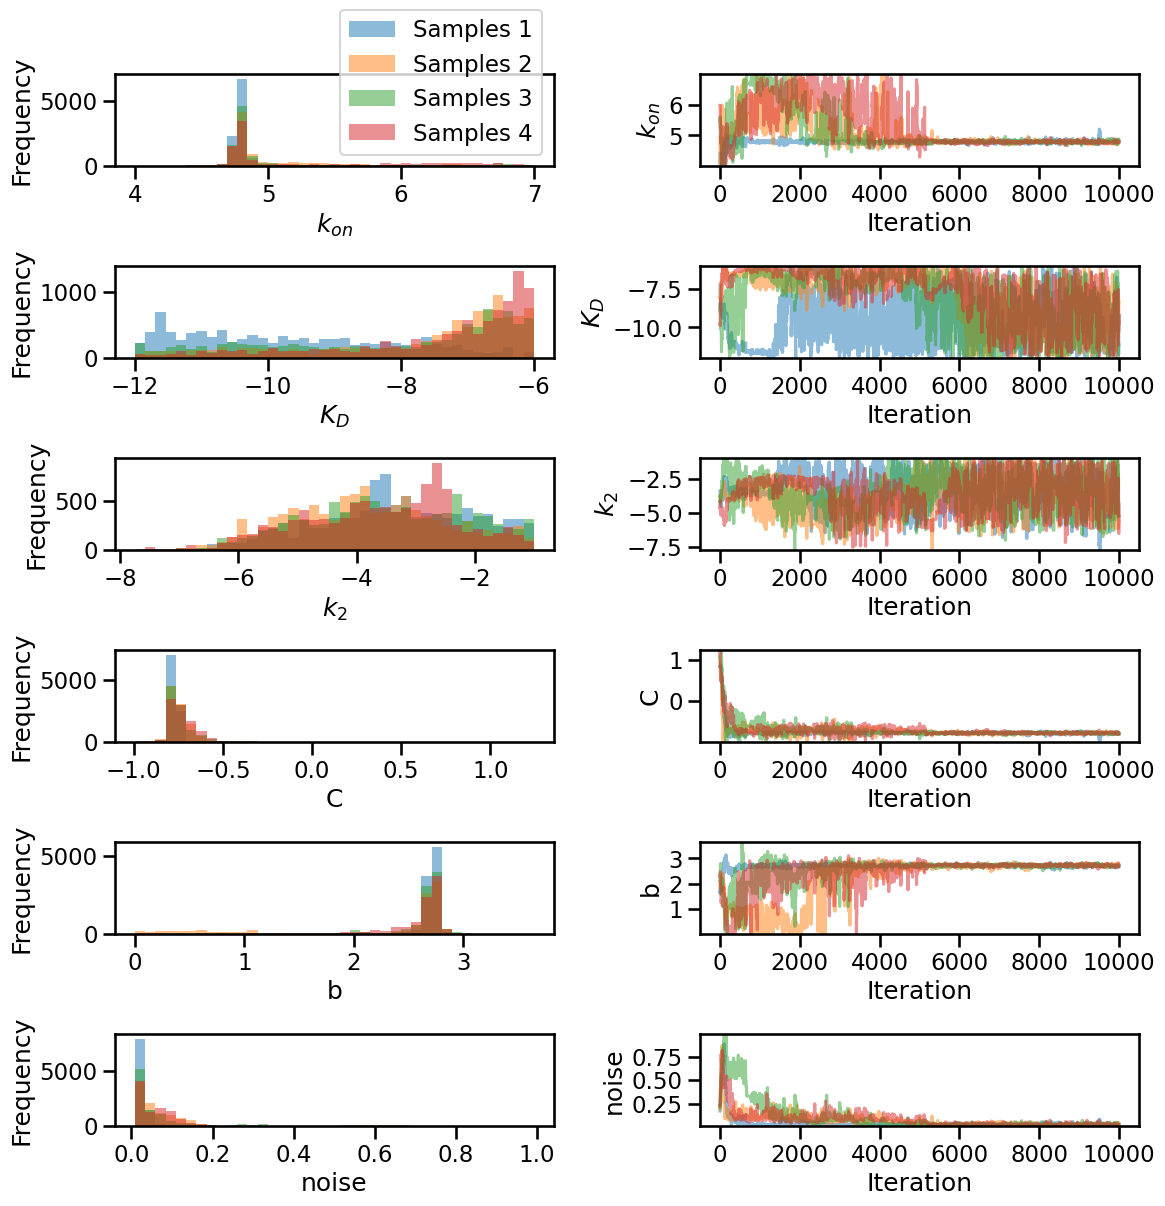

In [90]:
import pints.plot
parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C', 'b', 'noise']
pints.plot.trace(chains, parameter_names=parameter_names)
plt.show()

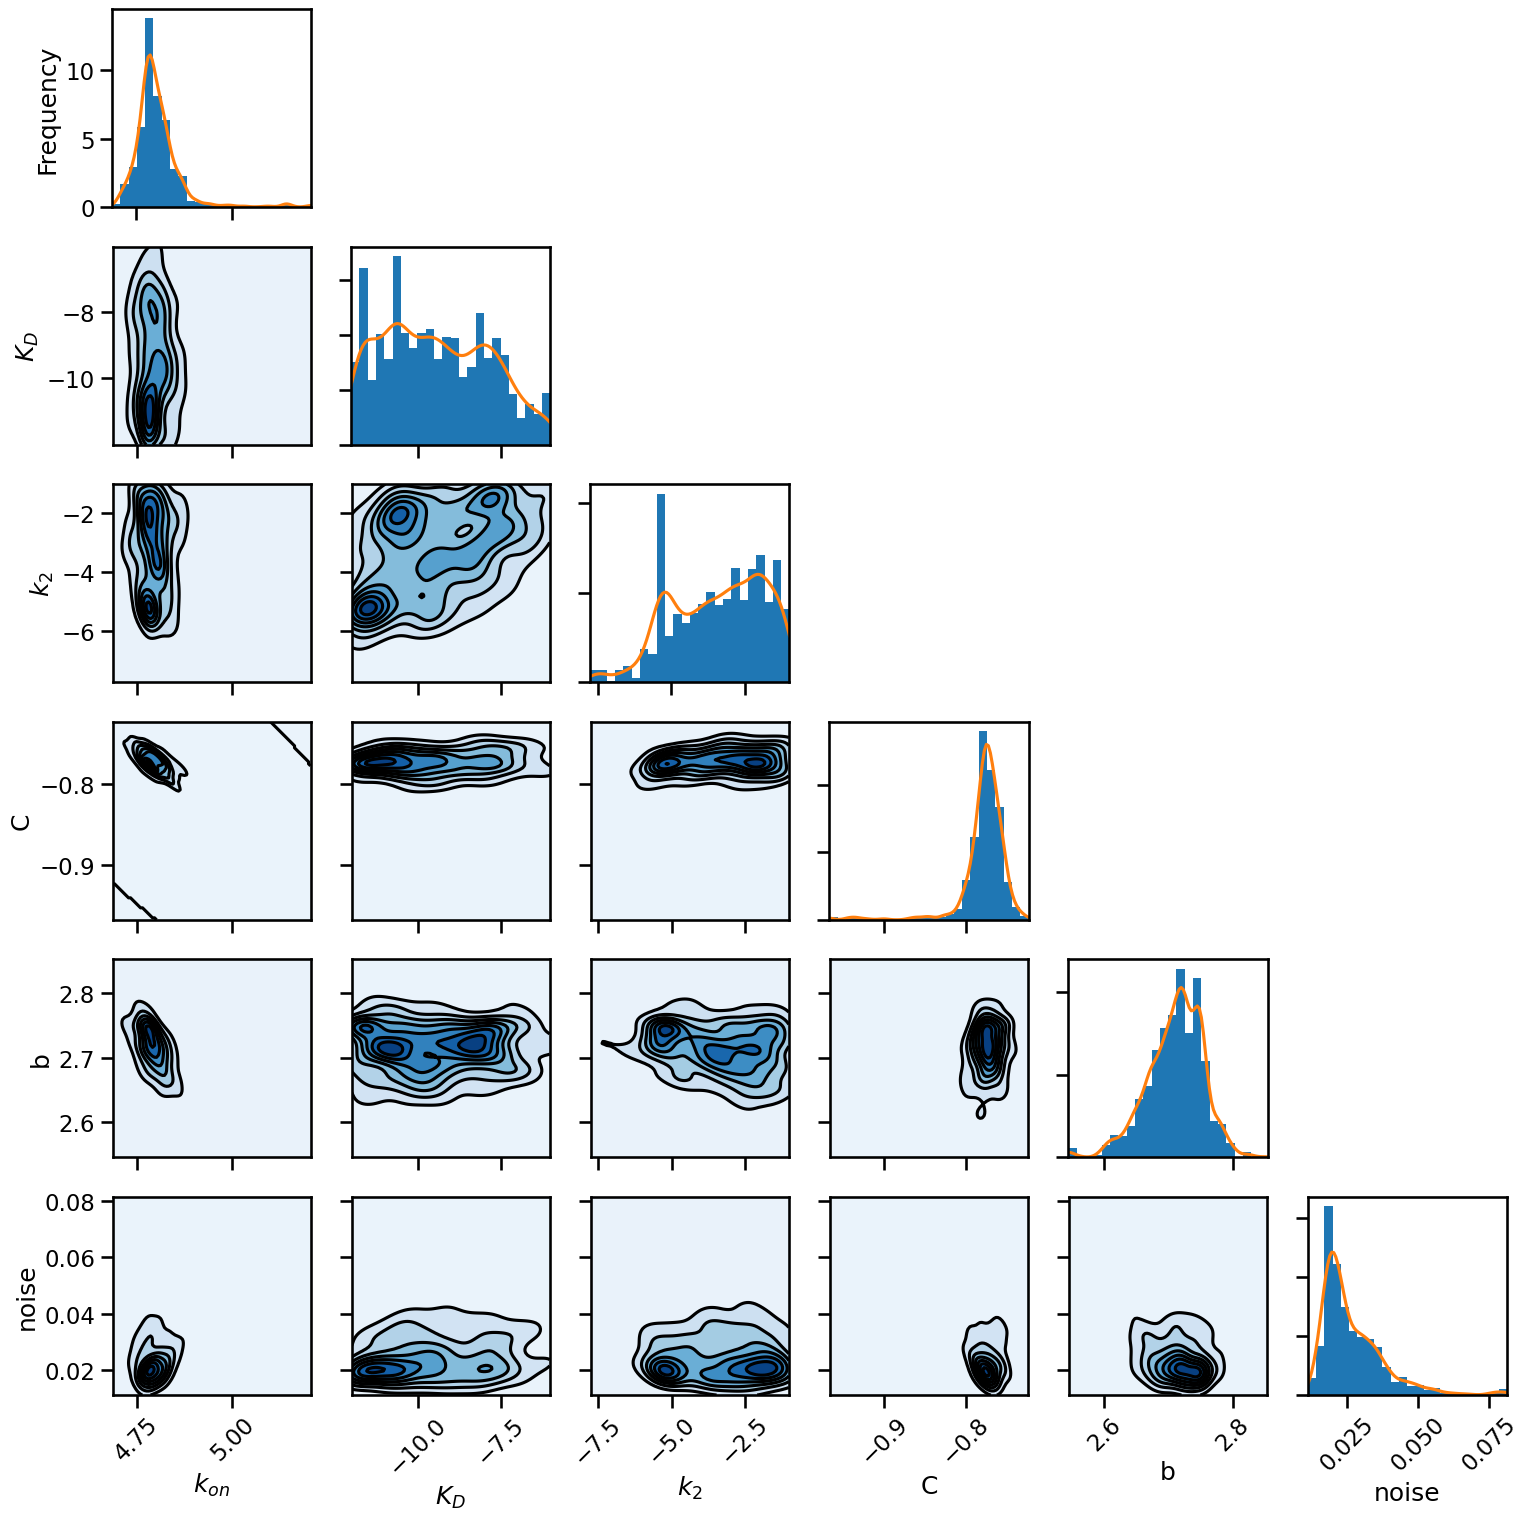

In [91]:
chain = chains[0]
chain = chain[8000:]
chains1 = chains[:, 8000 :]
pints.plot.pairwise(chain, kde=True,  parameter_names=parameter_names)
plt.show()

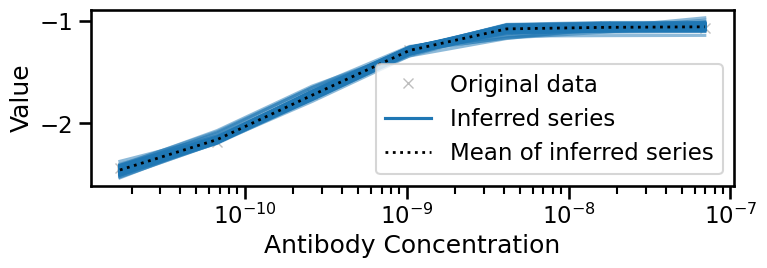

In [92]:
fig, axes = pints.plot.series(chains1[0], problem)

plt.legend()
plt.xscale('log')
plt.xlabel(r'Antibody Concentration')
plt.show()

In [93]:
results = pints.MCMCSummary(chains=chains1, time=mcmc.time(),parameter_names=parameter_names)
print(results)

param     mean    std.    2.5%    25%     50%    75%    97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  ------  -----  -----  -------  ------  ------  --------------
$k_{on}$  4.79    0.04    4.72    4.77    4.79   4.81   4.88     1.02    303.66  0.41
$K_D$     -9.39   1.58    -11.88  -10.69  -9.55  -8.11  -6.45    1.02    230.38  0.31
$k_2$     -3.45   1.47    -6.17   -4.64   -3.31  -2.21  -1.17    1.02    281.63  0.38
C         -0.77   0.02    -0.81   -0.78   -0.77  -0.76  -0.74    1.02    259.40  0.35
b         2.72    0.04    2.64    2.70    2.72   2.75   2.80     1.03    314.48  0.43
noise     0.03    0.01    0.01    0.02    0.02   0.03   0.05     1.03    222.86  0.30


In [94]:
results_list = results._summary_list
results_dic = {}
means =[]
stds = []
l_perc = []
h_perc = []
rhats = []
parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C','b']
for i, param in enumerate(parameter_names):
    holder = results_list[i]
    means.append(holder[1])
    stds.append(holder[2])
    l_perc.append(holder[3])
    h_perc.append(holder[7])
    rhats.append(holder[8])

results_dic['parameter'] = parameter_names
results_dic['mean'] = means
results_dic['std'] = stds
results_dic['2.5%'] = l_perc
results_dic['97.5%'] = h_perc
results_dic['rhat'] = rhats

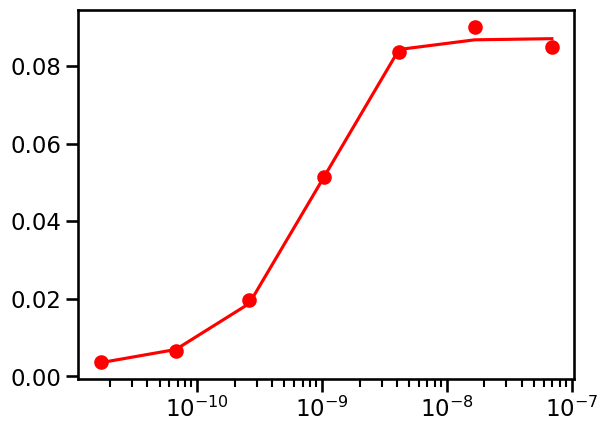

In [96]:
sim = simulate_model(conc, parameters=results_dic['mean'])
plt.semilogx(conc, 10**sim, label='fit', c='red')
plt.scatter(conc, 10**data, label='data', c='red')

In [98]:
class model(pints.ForwardModel):

    def n_outputs(self):
         return 1
    
    def n_parameters(self):
        return 3
    
    def simulate(self, parameters, A0s):
        return simulate_model1(A0s, parameters)

In [118]:
mod = model()
problem = pints.MultiOutputProblem(mod, conc, data)
log_likelihood = pints.GaussianLogLikelihood(problem)
parameters = [-4,  0.1, 2, 0.1]
log_prior = pints.UniformLogPrior(
    [-10, -2, 0, 0.0001],
    [-1, 1, 4, 0.5]
)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [119]:
xs = [
    np.array(parameters) * 0.85,
    np.array(parameters) * 0.95,
    np.array(parameters) * 1.05,
    np.array(parameters) * 1.15 
]

In [120]:
mcmc = pints.MCMCController(log_posterior, 4, xs)
mcmc.set_max_iterations(10000)
chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.1
1     8      0.5       0.5       0.5       0          0:00.3
2     12     0.333     0.333     0.667     0          0:00.4
3     16     0.25      0.5       0.5       0.25       0:00.5
20    84     0.524     0.571     0.619     0.476      0:02.7
40    164    0.415     0.512     0.634     0.512      0:04.6
60    244    0.426     0.492     0.656     0.557377   0:06.6
80    324    0.42      0.432     0.642     0.593      0:08.4
100   404    0.426     0.475     0.644     0.634      0:10.2
120   484    0.479     0.512     0.628     0.653      0:12.1
140   564    0.511     0.56      0.674     0.681      0:13.9
160   644    0.515528  0.578     0.652     0.708      0:15.5
180   724    0.547     0.575     0.652     0.724      0:17.1
Initial phase completed.
200   804    0.552     0.

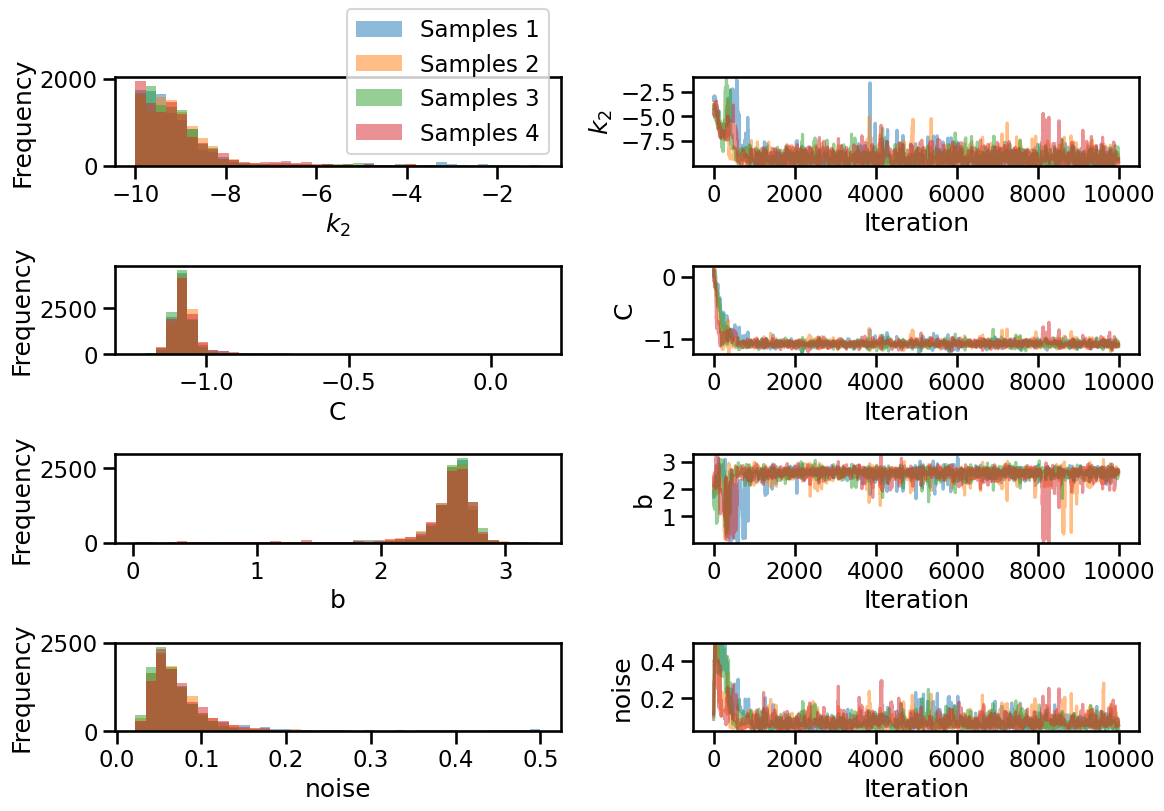

In [121]:
import pints.plot
parameter_names=[ r'$k_2$', 'C', 'b', 'noise']
pints.plot.trace(chains, parameter_names=parameter_names)
plt.show()

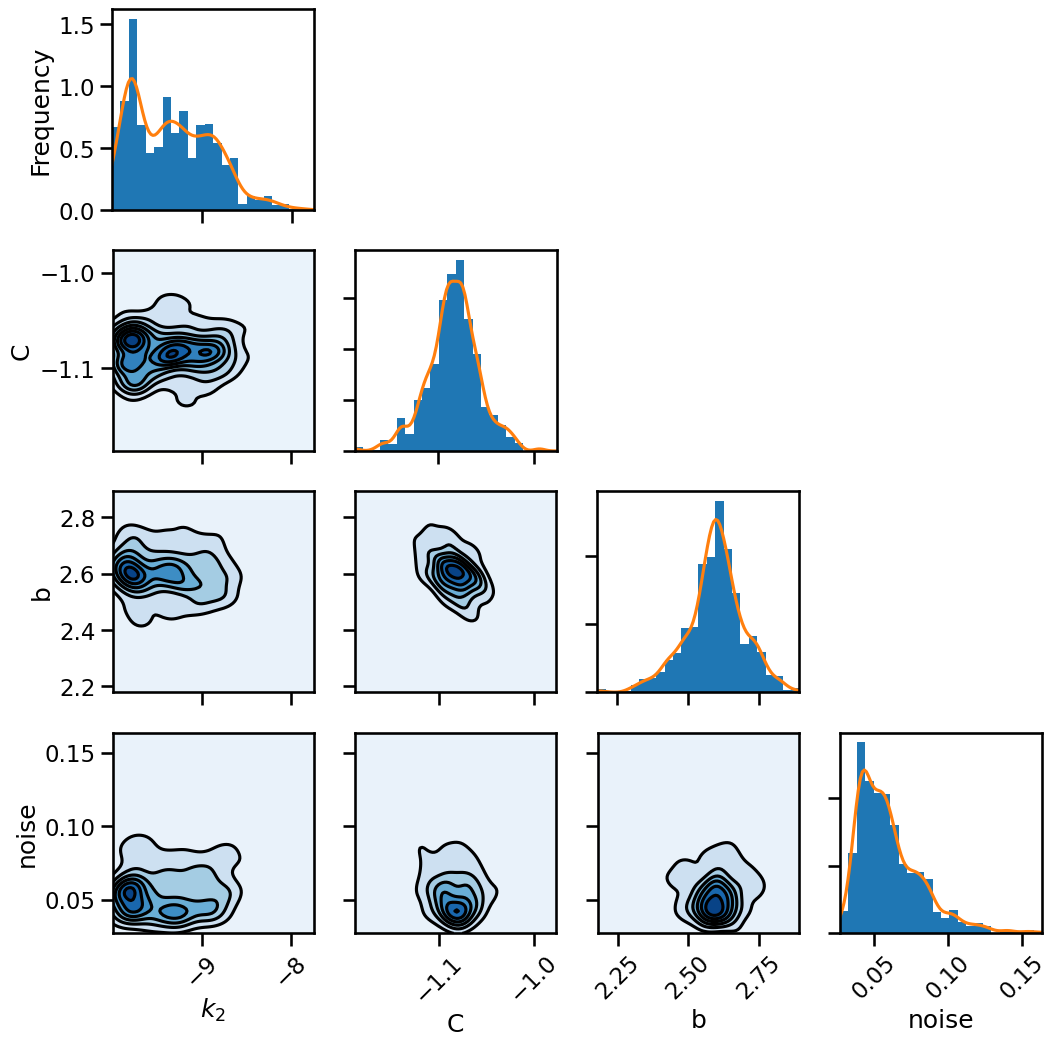

In [122]:
chain = chains[0]
chain = chain[8000:]
chains1 = chains[:, 8000 :]
pints.plot.pairwise(chain, kde=True,  parameter_names=parameter_names)
plt.show()

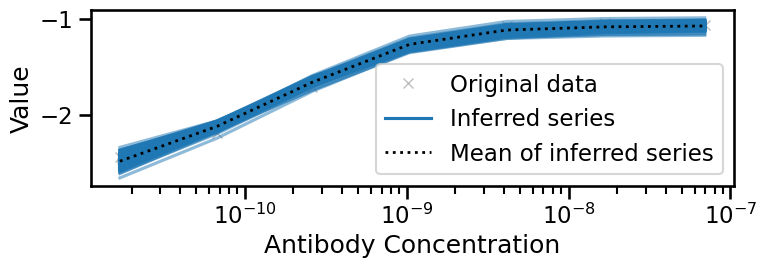

In [123]:
fig, axes = pints.plot.series(chains1[0], problem)

plt.legend()
plt.xscale('log')
plt.xlabel(r'Antibody Concentration')
plt.show()

In [124]:
results = pints.MCMCSummary(chains=chains1, time=mcmc.time(),parameter_names=parameter_names)
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
$k_2$    -9.21   0.61    -9.97   -9.71  -9.30  -8.89  -7.77    1.02    307.05  0.65
C        -1.08   0.04    -1.15   -1.10  -1.08  -1.06  -0.99    1.03    398.09  0.84
b        2.55    0.27    2.02    2.51   2.59   2.66   2.81     1.05    304.96  0.65
noise    0.07    0.03    0.04    0.05   0.06   0.08   0.14     1.05    304.89  0.65


In [125]:
results_list = results._summary_list
results_dic = {}
means =[]
stds = []
l_perc = []
h_perc = []
rhats = []
parameter_names=[ r'$k_2$', 'C','b']
for i, param in enumerate(parameter_names):
    holder = results_list[i]
    means.append(holder[1])
    stds.append(holder[2])
    l_perc.append(holder[3])
    h_perc.append(holder[7])
    rhats.append(holder[8])

results_dic['parameter'] = parameter_names
results_dic['mean'] = means
results_dic['std'] = stds
results_dic['2.5%'] = l_perc
results_dic['97.5%'] = h_perc
results_dic['rhat'] = rhats

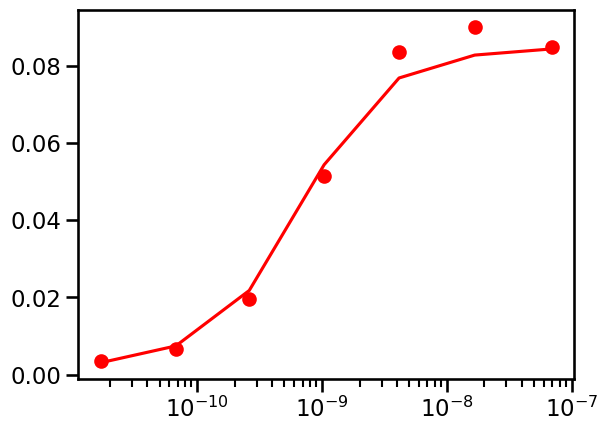

In [126]:
sim = simulate_model1(conc, parameters=results_dic['mean'])
plt.semilogx(conc, 10**sim, label='fit', c='red')
plt.scatter(conc, 10**data, label='data', c='red')